# IDS multiclass detection using NetTiSA flows

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import lightgbm as lgb
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE



In [2]:
df = pd.read_csv("./database_multiclass_ipfixprobe.csv")

In [3]:
features = [
        'SRC_PORT',
        'DST_PORT',
        'BYTES',
        'BYTES_REV',
        'AVERAGE_DISPERSION', 
        'KURTOSIS',
        'MAX_DIFFTIMES', 
        'MEAN', 
        'MEAN_DIFFTIMES',
        'MEAN_SCALED_TIME', 
        'MIN_DIFFTIMES',
        'ROOT_MEAN_SQUARE', 
        'STDEV',
        'SWITCHING_RATIO', 
        'TIME_DISTRIBUTION',
        'PACKETS', 
        'PACKETS_REV', 
        'MAX', 
        'MIN', 
        'MIN_MINUS_MAX',
        'PERCENT_DEVIATION', 
        'VARIANCE',
        'BURTINESS', 
        'COEFFICIENT_OF_VARIATION',
        'DIRECTIONS', 
        'DURATION', 
]

In [4]:
import sklearn
pd.set_option('display.max_columns', None)

df = df[["LABEL"] + features].copy()

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes


for F in features:
    df.replace([np.inf], 0, inplace=True)
    df.replace([-np.inf], 0, inplace=True)
    df.loc[df[F].isnull(), F] = 0

In [5]:
df

,LABEL,SRC_PORT,DST_PORT,BYTES,BYTES_REV,AVERAGE_DISPERSION,KURTOSIS,MAX_DIFFTIMES,MEAN,MEAN_DIFFTIMES,MEAN_SCALED_TIME,MIN_DIFFTIMES,ROOT_MEAN_SQUARE,STDEV,SWITCHING_RATIO,TIME_DISTRIBUTION,PACKETS,PACKETS_REV,MAX,MIN,MIN_MINUS_MAX,PERCENT_DEVIATION,VARIANCE,BURTINESS,COEFFICIENT_OF_VARIATION,DIRECTIONS,DURATION,LABEL_code
0,Exploits,7302,80,938,336,49.904728,8.817814,259993.0,28.111111,29802.888672,3.039079e+05,0.0,84.333336,79.549423,0.666667,0.145633,10,8,253,0,253,1.775267,6328.110700,0.477782,2.829821,0.555556,0.536452,4
1,Clear,22592,143,710,42002,607.387329,1.939034,118119.0,781.384521,12498.114258,3.837693e+05,0.0,1048.738037,699.921692,0.403846,0.181585,14,38,1460,0,1460,0.777322,489890.374932,-0.054994,0.895746,0.269231,0.649902,2
2,Clear,32473,80,986,256,57.267792,8.020354,99324.0,34.625004,21126.062500,2.010252e+05,0.0,97.934288,91.842934,0.625000,0.232682,10,6,277,0,277,1.653943,8435.124526,0.452430,2.652503,0.625000,0.338017,2
3,Clear,1325,514,1200,0,286.000000,0.000000,11.0,572.000000,5.500000,5.500000e+00,0.0,572.000000,0.000000,0.500000,-0.009804,2,0,572,572,0,0.500000,0.000000,-1.000000,0.000000,1.000000,0.000011,2
4,Clear,40220,514,942,0,221.500000,0.000000,11.0,443.000000,5.500000,5.500000e+00,0.0,443.000000,0.000000,0.500000,-0.012731,2,0,443,443,0,0.500000,0.000000,-1.000000,0.000000,1.000000,0.000011,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953400,Clear,23336,25,37310,3380,422.438446,3.379862,84310.0,380.702209,6859.926758,2.871488e+05,0.0,725.660767,618.209961,0.393617,0.115638,52,42,1448,0,1448,1.109630,382183.555880,0.237766,1.623868,0.553191,0.644833,2
1953401,Clear,20997,21,2044,2404,12.384136,4.107973,623250.0,11.314287,25978.988281,1.108748e+06,0.0,20.021418,16.728931,0.485714,0.073118,36,34,54,0,54,1.094557,279.857132,0.193082,1.478567,0.514286,1.818529,2
1953402,Clear,21438,63384,3302,40550,365.320526,3.433541,1748.0,346.509064,190.309097,8.214510e+03,0.0,650.926758,551.352539,0.454545,0.114844,54,56,1300,0,1300,1.054289,303989.622262,0.228146,1.591163,0.490909,0.020934,2
1953403,Clear,19878,17782,3302,40550,365.320526,3.433541,2807.0,346.509064,215.936325,9.588800e+03,0.0,650.926758,551.352539,0.454545,0.083934,54,56,1300,0,1300,1.054289,303989.622262,0.228146,1.591163,0.490909,0.023753,2


In [6]:
df[["LABEL", "LABEL_code"]].drop_duplicates().sort_values("LABEL_code")

,LABEL,LABEL_code
122425,Analysis,0
57,Backdoor,1
1,Clear,2
303,DoS,3
0,Exploits,4
28,Fuzzers,5
320,Generic,6
163,Reconnaissance,7
2129,Shellcode,8
8792,Worms,9


In [7]:
classifications_array = []
for index, row in df[["LABEL", "LABEL_code"]].drop_duplicates().sort_values("LABEL_code").iterrows():
    classifications_array.append(row[0])
classifications_array

['Analysis',
 'Backdoor',
 'Clear',
 'DoS',
 'Exploits',
 'Fuzzers',
 'Generic',
 'Reconnaissance',
 'Shellcode',
 'Worms']

In [8]:
df = df[["LABEL_code"] + features].copy()

In [9]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [10]:
df.LABEL_code.value_counts()

2.0    1885083
4.0      23150
5.0      18792
7.0      10999
1.0       6484
6.0       3674
3.0       3348
8.0       1385
0.0        335
9.0        155
Name: LABEL_code, dtype: int64

In [13]:
# df.LABEL_code.value_counts()

In [14]:
X = df[features]
y = df.LABEL_code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test

X_train['LABEL_code'] = y_train
df_features = X_train

X_test['LABEL_code'] = y_test
df_validation = X_test

# df_validation = df.sample(n=1000000)
# df_features =  df[~df.isin(df_validation)].dropna()

In [16]:
df_features.LABEL_code.value_counts()

2.0    1319558
4.0      16205
5.0      13154
7.0       7699
1.0       4539
6.0       2572
3.0       2344
8.0        969
0.0        234
9.0        109
Name: LABEL_code, dtype: int64

In [17]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [18]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        # base_score=float(space['base_score']),
                        n_estimators = int(space['n_estimators']), 
                        max_depth = int(space['max_depth']), 
                        gamma = space['gamma'],
                        reg_alpha = float(space['reg_alpha']),
                        min_child_weight=int(space['min_child_weight']),
                        reg_lambda = float(space['reg_lambda']),
                        colsample_bytree=float(space['colsample_bytree']), 
                        # colsample_bytree=float(space['colsample_bytree']), 
                        # subsample=float(space['subsample']),
                        # eta=space['eta'],
                            )

        classes_weights = list(class_weight.compute_class_weight('balanced',
                                                    classes=np.unique(y_train),
                                                    y=y_train))

        weights = np.ones(y_train.shape[0], dtype = 'float')
        for i, val in enumerate(y_train):
            weights[i] = classes_weights[int(val-1)]

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False, sample_weight=weights)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred,average='macro')
        if verbose is True:
            print ("SCORE:", accuracy, "  ", space)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 50, 5),
        'gamma': hp.uniform ('gamma', 1,18),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,2),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 300, 20),
        # 'subsample': hp.uniform('subsample', 0, 1),
        # 'base_score': hp.uniform('subsample', 0, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [20]:
# df_to_tune = df_features.sample(n=100000)
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [17:03:34<00:00, 614.15s/trial, best loss: -0.703809675699727]   
The best hyperparameters are :  

{'colsample_bytree': 0.8546564894558571, 'gamma': 5.402901507581192, 'max_depth': 45.0, 'min_child_weight': 14.0, 'n_estimators': 220.0, 'reg_alpha': 6.0, 'reg_lambda': 0.16727523026347396}


In [25]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      # X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      # X_train = X_train_a[features]
      # X_test = X_test_a[features] 
      model = XGBClassifier(
      n_estimators = int(best_hyperparams['n_estimators']), 
                        max_depth = int(best_hyperparams['max_depth']), 
                        gamma = best_hyperparams['gamma'],
                        reg_alpha = float(best_hyperparams['reg_alpha']),
                        min_child_weight=int(best_hyperparams['min_child_weight']),
                        reg_lambda = float(best_hyperparams['reg_lambda']),
                        colsample_bytree=float(best_hyperparams['colsample_bytree']), ) # , sample_weight=weights
      model.fit(X, y)
      # model.fit(X_train, y_train)
      # y_pred = model.predict(X_test)
      # print(classification_report(y_test, y_pred, target_names=classifications_array, digits=4))
      return model

In [26]:
model = XGBoost_classification_tunned(best_hyperparams)

In [28]:
def while_XGBoost_classification_tunned_old(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best = 0
    best_model = None
    report = None
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        #Split on train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) # 70% training and 30% test
        
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
        )
        model.fit(X_train, y_train, ) # eval_set=evaluation, eval_metric=["auc","error","logloss"], verbose=False
        y_pred = model.predict(X_test)
        
        F1 = f1_score(y_test, y_pred, average='micro')
        if F1 > best:   
            best = F1
            best_model = model
            report = classification_report(y_test, y_pred, target_names=classifications_array, digits=4)
        
    print("")
    print(report)
    return best_model

In [29]:
best_model = while_XGBoost_classification_tunned_old(best_hyperparams, cycles=25)

24
                precision    recall  f1-score   support

      Analysis     0.0000    0.0000    0.0000       190
      Backdoor     0.6190    0.1757    0.2737       148
         Clear     0.9867    0.9965    0.9916    719207
           DoS     0.5632    0.0337    0.0636      1455
      Exploits     0.6716    0.6903    0.6808     11155
       Fuzzers     0.6598    0.3646    0.4696      6723
       Generic     0.6791    0.2699    0.3863      1419
Reconnaissance     0.8649    0.4275    0.5722      3144
     Shellcode     0.3250    0.0388    0.0693       335
         Worms     0.6154    0.1290    0.2133        62

      accuracy                         0.9796    743838
     macro avg     0.5985    0.3126    0.3720    743838
  weighted avg     0.9764    0.9796    0.9766    743838



In [27]:
best_model = model

In [28]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
y_pred = best_model.predict(X_validation)
print(classification_report(y_validation, y_pred, target_names=classifications_array, digits=4))

                precision    recall  f1-score   support

      Analysis     0.0000    0.0000    0.0000       101
      Backdoor     0.9498    0.9728    0.9611      1945
         Clear     0.9949    0.9966    0.9957    565525
           DoS     0.6881    0.2241    0.3381      1004
      Exploits     0.7927    0.8976    0.8419      6945
       Fuzzers     0.6939    0.5725    0.6274      5638
       Generic     0.8104    0.7214    0.7633      1102
Reconnaissance     0.8992    0.8809    0.8899      3300
     Shellcode     0.8049    0.8726    0.8374       416
         Worms     0.5750    0.5000    0.5349        46

      accuracy                         0.9885    586022
     macro avg     0.7209    0.6639    0.6790    586022
  weighted avg     0.9877    0.9885    0.9878    586022



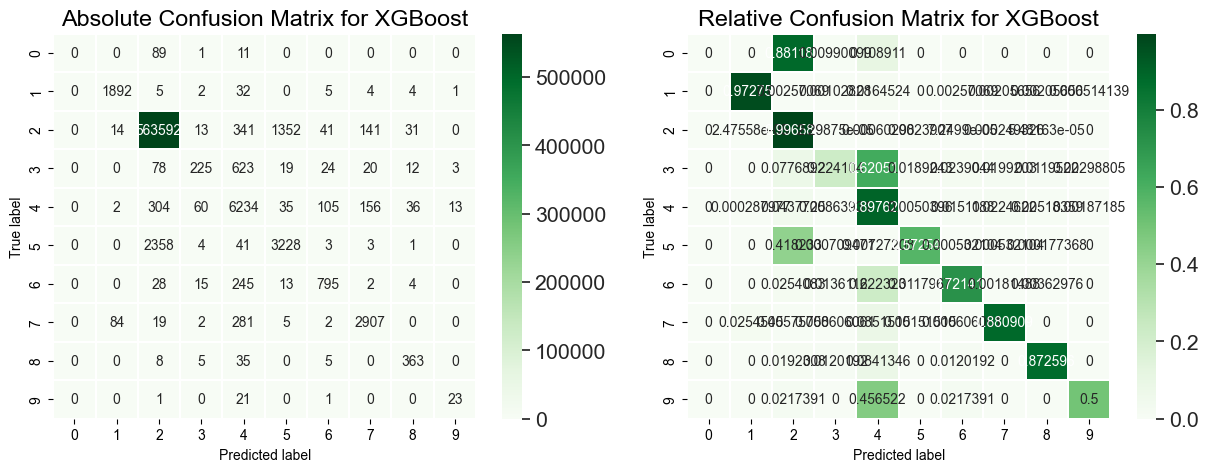

In [29]:
matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

# Feature importance

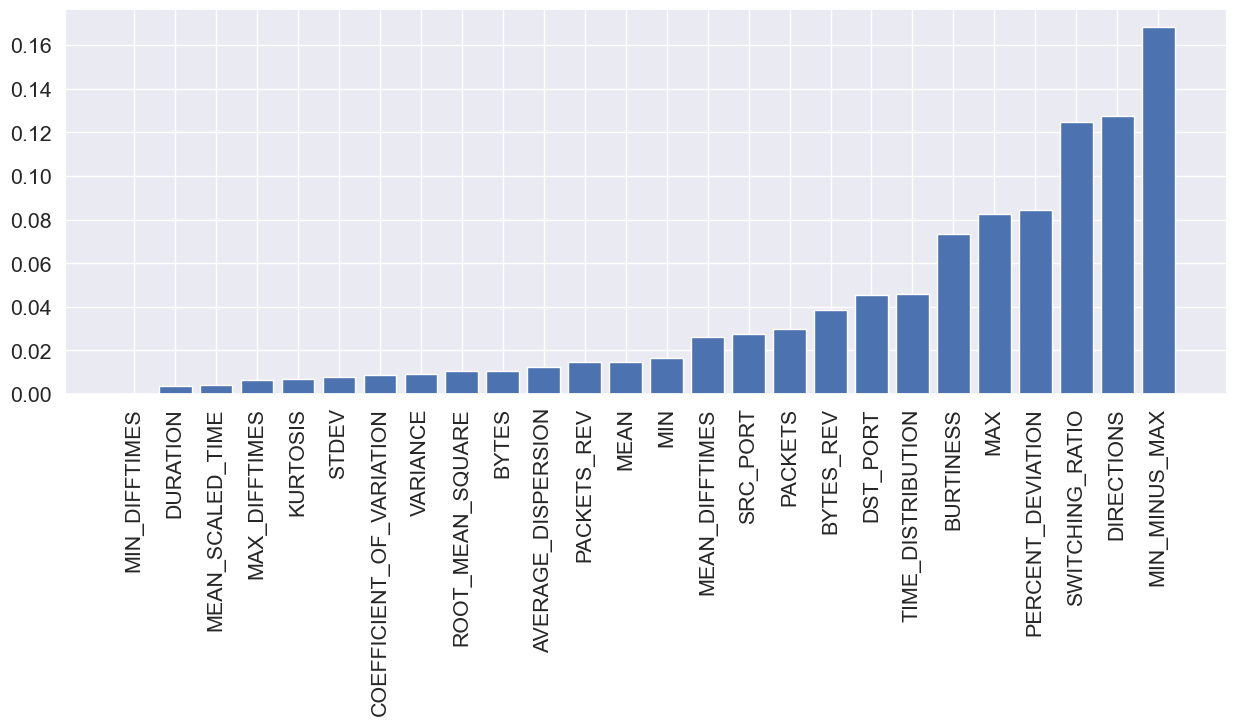

In [35]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [37]:
feat_importances.to_dict()

{'MIN_DIFFTIMES': 0.0,
 'DURATION': 0.0036050877533853054,
 'MEAN_SCALED_TIME': 0.004149261862039566,
 'MAX_DIFFTIMES': 0.0064584556967020035,
 'KURTOSIS': 0.007045036181807518,
 'STDEV': 0.00788311567157507,
 'COEFFICIENT_OF_VARIATION': 0.008670474402606487,
 'VARIANCE': 0.009028750471770763,
 'ROOT_MEAN_SQUARE': 0.010409696958959103,
 'BYTES': 0.010446474887430668,
 'AVERAGE_DISPERSION': 0.012436125427484512,
 'PACKETS_REV': 0.014713698998093605,
 'MEAN': 0.014727494679391384,
 'MIN': 0.01655314862728119,
 'MEAN_DIFFTIMES': 0.02615353651344776,
 'SRC_PORT': 0.027526333928108215,
 'PACKETS': 0.030010756105184555,
 'BYTES_REV': 0.03860099986195564,
 'DST_PORT': 0.045386068522930145,
 'TIME_DISTRIBUTION': 0.04577569663524628,
 'BURTINESS': 0.07350390404462814,
 'MAX': 0.08231832832098007,
 'PERCENT_DEVIATION': 0.08450613170862198,
 'SWITCHING_RATIO': 0.12450963258743286,
 'DIRECTIONS': 0.12752564251422882,
 'MIN_MINUS_MAX': 0.1680561751127243}